# Face Mask Detector

Este notebook implementa uma versão otimizada da CNN MobileNetV2, com o intuito de detectar se a pessoa está ou não está usando máscara, a partir de uma foto. Nessa versão otimizada não se usa Transfer Learning, ou seja, o modelo será treinado do zero. Isso foi feito com o intuito de diminuir o `alpha` para valores ainda menores que os determinados no Transfer Learning, deixando o modelo ainda mais leve a fim de ser possível embarcar na ESP32-CAM.  

## Fases do Projeto
1. **Preparação dos Dados**: Download e pré-processamento.
2. **Data Augmentation**: Essencial aqui, pois vamos aprender do zero.
3. **Treinamento Completo**: Uma única fase longa de treinamento.
4. **Exportação**: Conversão para TFLite (INT8).

---


## 1. Configuração Inicial


In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import tensorflow as tf
from collections import Counter
from sklearn.metrics import confusion_matrix
import glob

# Utilitários do Keras
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Constantes e Hiperparâmetros
BATCH_SIZE = 32
IMG_SIZE = (64, 64) # Tamanho da imagem
IMG_SHAPE = IMG_SIZE + (3,)
SEED = 42

print(f"Versão do TensorFlow: {tf.__version__}")


c:\Users\josel\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Versão do TensorFlow: 2.20.0


## 2. Download dos Dados (KaggleHub)


In [2]:
print("Baixando Dataset...")
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")
DATA_DIR = os.path.join(path, "data")

train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='training',
    seed=SEED
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset='validation',
    seed=SEED
)

class_names = train_dataset.class_names
print(f"Classes: {class_names}")


Baixando Dataset...
Found 7553 files belonging to 2 classes.
Using 6043 files for training.
Found 7553 files belonging to 2 classes.
Using 1510 files for validation.
Classes: ['with_mask', 'without_mask']


## 3. Visualização


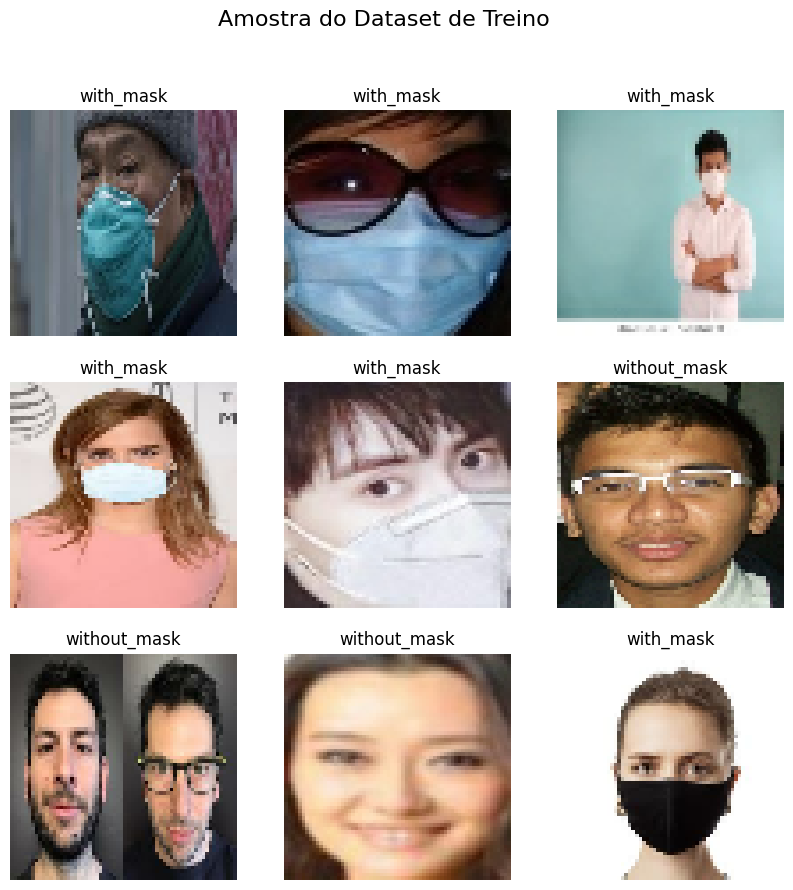

In [3]:
# Visualiza um grid 3x3 com imagens e seus rótulos
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Amostra do Dataset de Treino", fontsize=16)
plt.show()

## 4. Pré-processamento e Augmentation


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

def preprocess_train(image, label):
    image = data_augmentation(image)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

def preprocess_val(image, label):
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

train_dataset = train_dataset.map(preprocess_train, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_val, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)


## 5. Construção do Modelo
Isso é o que torna o modelo leve: `weights=None` e `alpha=0.25`.


In [ ]:
print("Construindo MobileNetV2 do ZERO (Alpha=0.25)...")

# Base
base_model = MobileNetV2(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights=None,   # <--- Sem pesos pré-treinados
    alpha=0.25       # <--- Rede extremamente pequena
)

# Como não tem pesos pré-treinados, treinamos TUDO desde o início
base_model.trainable = True

inputs = Input(shape=IMG_SHAPE)
x = base_model(inputs)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x) # Dropout pequeno pois a rede já é pequena e tem poucos params
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-3), # LR normal para começar do zero
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()


Construindo MobileNetV2 do ZERO (Alpha=0.1)...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_0.25_64             │ (None, 2, 2, 1280)     │       248,768 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,330 (981.76 KB)

 Trainable params: 240,674 (940.13 KB)

 Non-trainable params: 10,656 (41.62 KB)

## 6. Treinamento (Scratch)
Treinamos por mais épocas para compensar a falta de pré-treino.


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

print("\nIniciando Treinamento Completo...")

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30, # Usando uma grande quantidade de épocas
    callbacks=[early_stop, reduce_lr]
)



Iniciando Treinamento Completo...
Epoch 1/30


## 7. Resultados


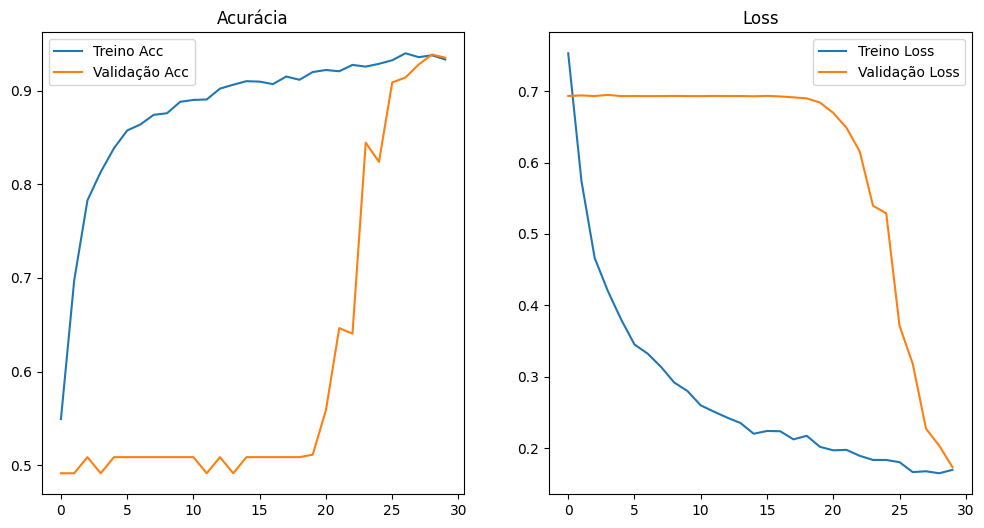


📊 Diagnóstico Final:
   Acurácia Treino: 93.31%
   Acurácia Validação: 93.51%
   GAP: -0.20%
✅ Modelo Generalizando Bem!


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Treino Acc')
plt.plot(val_acc, label='Validação Acc')
plt.legend()
plt.title('Acurácia')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Treino Loss')
plt.plot(val_loss, label='Validação Loss')
plt.legend()
plt.title('Loss')
plt.show()

# Diagnóstico de Overfitting
final_train_acc = acc[-1]
final_val_acc = val_acc[-1]
gap = final_train_acc - final_val_acc

print(f"\nDiagnóstico Final:")
print(f"Acurácia Treino: {final_train_acc*100:.2f}%")
print(f"Acurácia Validação: {final_val_acc*100:.2f}%")
print(f"GAP: {gap*100:.2f}%")

if gap > 0.10:
    print("ALERTA: Possível Overfitting (Gap > 10%)")
else:
    print("Modelo Generalizando Bem!")


## 8. Teste Externo (Prova Real)
Validamos o modelo com um dataset TOTALMENTE NOVO que o modelo nunca viu.


In [ ]:
print("\nBaixando Dataset de Teste Externo...")
test_path = kagglehub.dataset_download("belsonraja/face-mask-dataset-with-and-without-mask")
TEST_DIR = os.path.join(test_path, "facemask-dataset", "dataset")

test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Aplica apenas o preprocessamento de validação (normalização)
test_dataset = test_dataset.map(preprocess_val).prefetch(AUTOTUNE)

print("\nAvaliando no Dataset Externo...")
external_loss, external_acc = model.evaluate(test_dataset)
print(f"Acurácia no Teste Externo: {external_acc*100:.2f}%")



🌍 Baixando Dataset de Teste Externo...
Found 3833 files belonging to 2 classes.

🧪 Avaliando no Dataset Externo...
120/120 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.9463 - loss: 0.1458
🏆 Acurácia no Teste Externo: 94.63%


### 8.1 Visualização das Predições no Teste


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


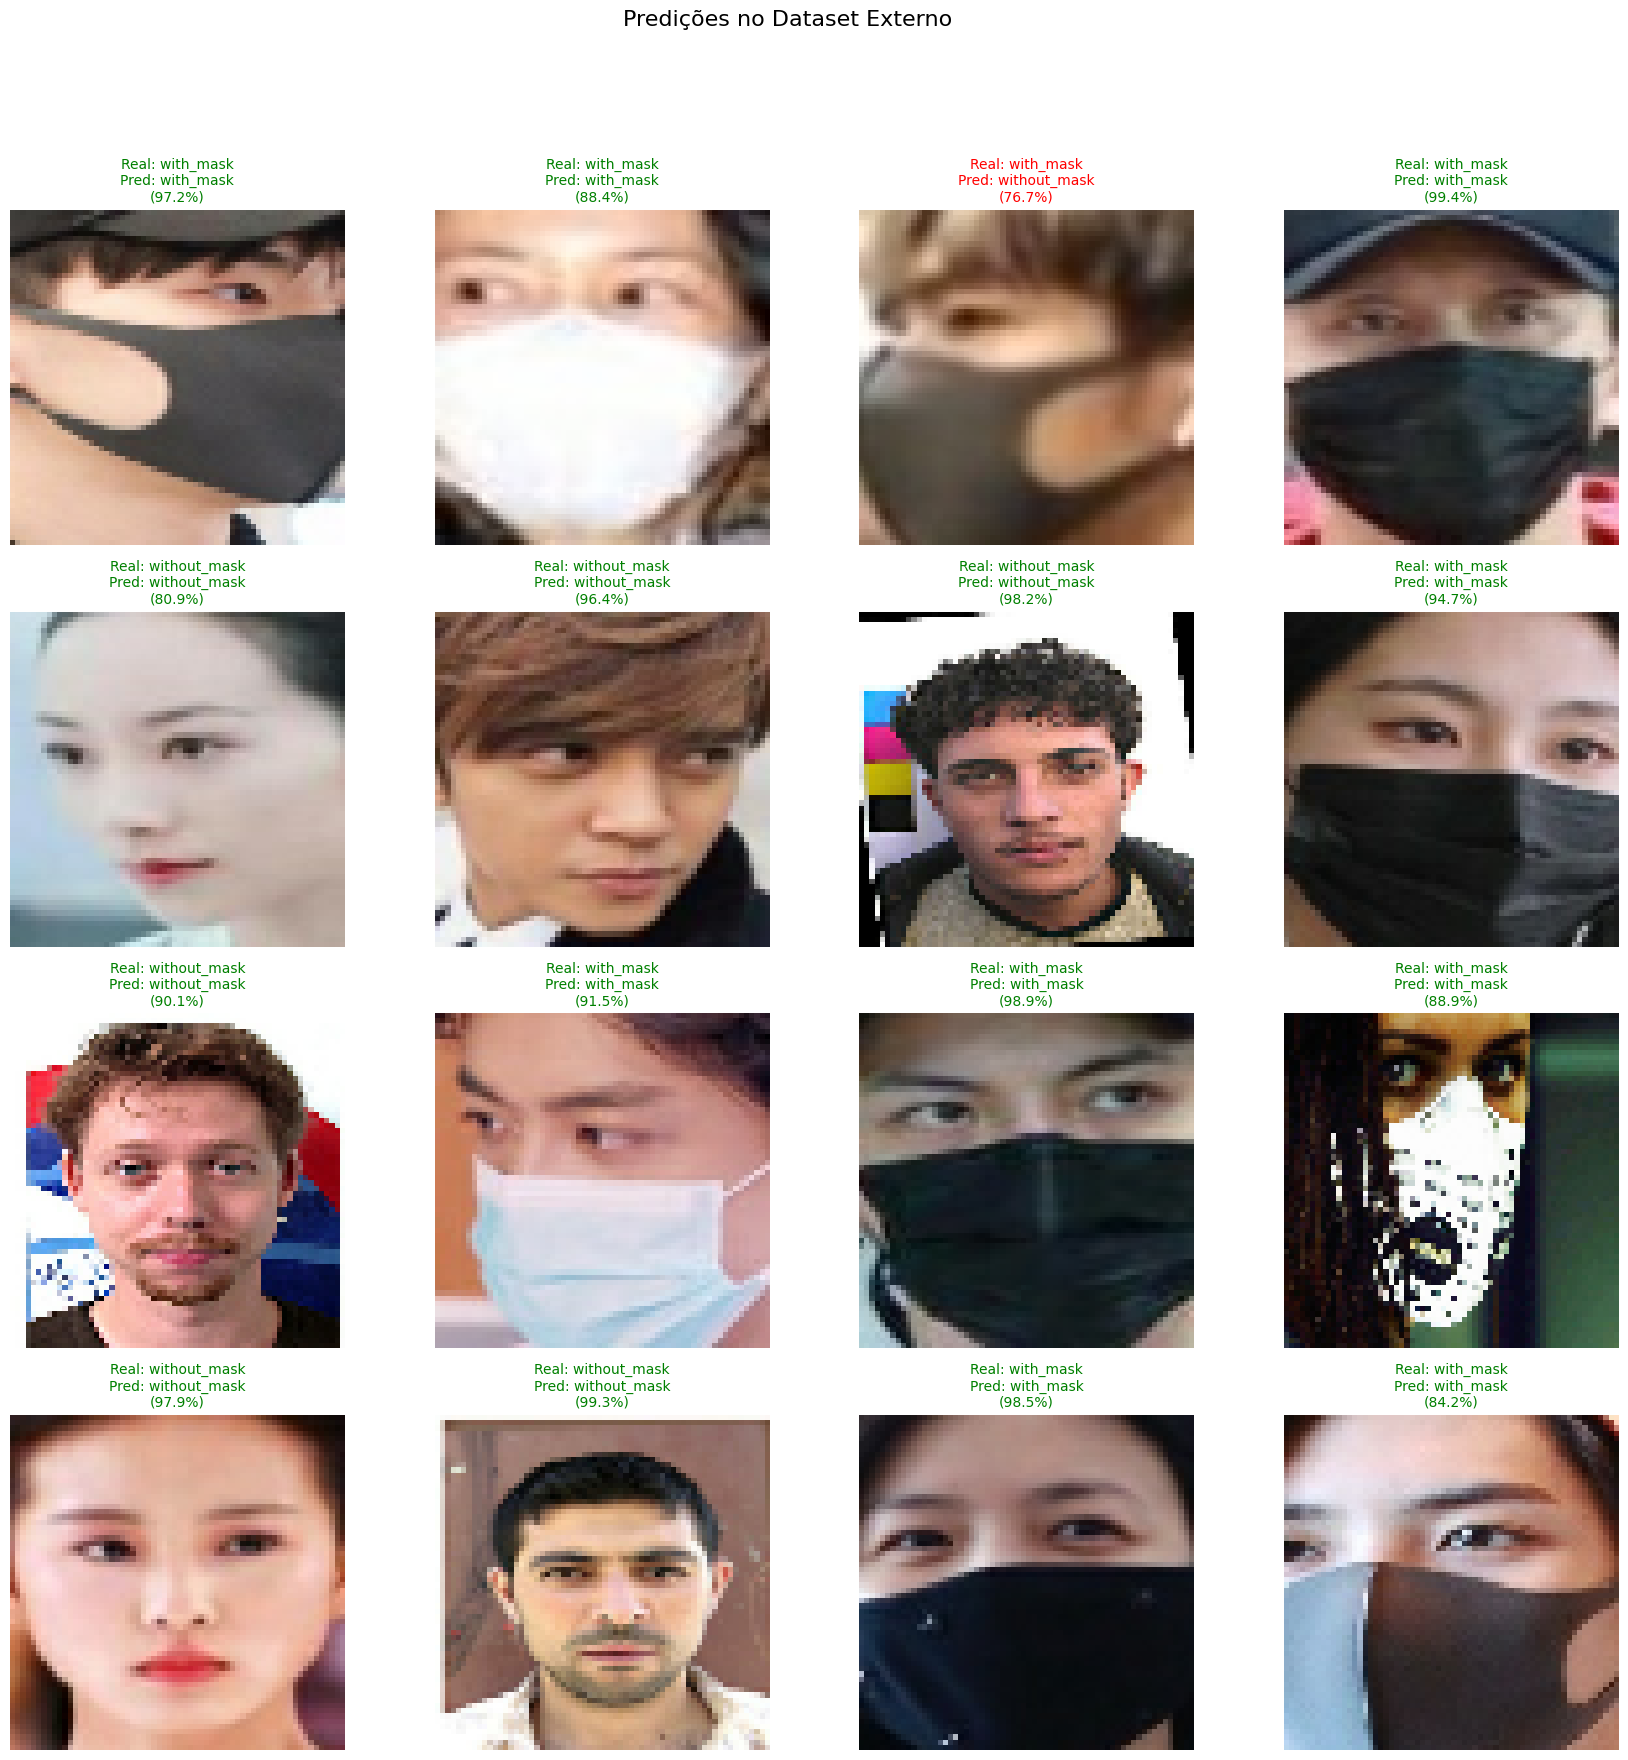

In [ ]:
# Pega um batch de imagens
image_batch, label_batch = next(iter(test_dataset))
predictions = model.predict(image_batch)
predicted_classes = np.argmax(predictions, axis=1)

test_class_names = class_names # Classes salvas anteriormente

plt.figure(figsize=(21, 20))
for i in range(min(16, len(image_batch))):
    ax = plt.subplot(4, 4, i + 1)
    
    # Desnormaliza para mostrar
    img_show = (image_batch[i] + 1) / 2
    plt.imshow(img_show)
    
    true_label = test_class_names[label_batch[i]]
    pred_label = test_class_names[predicted_classes[i]]
    confidence = np.max(predictions[i]) * 100
    
    color = "green" if true_label == pred_label else "red"
    
    plt.title(f"Real: {true_label}\nPred: {pred_label}\n({confidence:.1f}%)", color=color, fontsize=10)
    plt.axis("off")
plt.suptitle("Predições no Dataset Externo", fontsize=16)
plt.show()


## 9. Exportação Otimizada


In [ ]:
model.save("mask_detector_light.keras")

# TFLite Conversion
print("\nConvertendo para TFLite INT8...")
def representative_data_gen():
    for input_value, _ in train_dataset.take(100):
        yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

tflite_path = "mask_detector_light_int8.tflite"
with open(tflite_path, "wb") as f:
    f.write(tflite_model)

size_kb = os.path.getsize(tflite_path) / 1024
print(f"Modelo TFLite salvo: {tflite_path}")
print(f"Tamanho Final: {size_kb:.2f} KB")

# Foi dada uma meta de 400kb para o tamanho do tflite quantizado

if size_kb < 400:
    print("SUCESSO! Meta de < 400KB atingida.")
else:
    print("Ainda acima de 400KB.")


🔄 Convertendo para TFLite INT8...
INFO:tensorflow:Assets written to: C:\Users\josel\AppData\Local\Temp\tmpathjlcfm\assets


INFO:tensorflow:Assets written to: C:\Users\josel\AppData\Local\Temp\tmpathjlcfm\assets


Saved artifact at 'C:\Users\josel\AppData\Local\Temp\tmpathjlcfm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='keras_tensor_160')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2859220347088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2859220351888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2859220352656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2859220352272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2859220351504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2859220352848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2859234052240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2859234052432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2859234051280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2859234050704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  285

c:\Users\josel\AppData\Local\Programs\Python\Python311\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


✅ Modelo TFLite salvo: mask_detector_light_int8.tflite
📦 Tamanho Final: 411.41 KB
⚠️ Ainda acima de 400KB. Tente reduzir input_shape ou alpha.
